In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import seaborn as sns

# Instrumental Variables

### Not controlling for unknown confounder

In [225]:
num = 100000
np.random.seed(0)
Z = np.random.normal(0, 1, num) # Instrument
W = np.random.normal(0, 1, num) # Confounder
A = -1
B = -1
X = np.random.binomial(1, 1 / (1 + np.exp(-(A * Z + B * W)))) # treatment
Y = 2.5 * W + 1.5 * X + np.random.normal(0, 1, num) # outcome
df = pd.DataFrame({"Z": Z, "W": W, "X": X, "Y": Y})

In [226]:
np.bincount(np.random.binomial(1, 0.5, 1000))

array([499, 501])

In [227]:
results = sm.OLS(df["X"], sm.add_constant(df["Z"])).fit()
X_predicted = results.predict(sm.add_constant(df[["Z"]]))

In [228]:
results2 = sm.OLS(df["Y"], sm.add_constant(X_predicted)).fit()
results2.params

const    0.040599
0        1.454066
dtype: float64

In [229]:
np.cov(Y, Z)[0, 1] / np.cov(X, Z)[0, 1]

1.4540661677413842

### Controlling for known confounder

In [230]:
results = sm.OLS(df["Y"], sm.add_constant(df[["X", "W"]])).fit()
results.params

const    0.008395
X        1.493139
W        2.493249
dtype: float64

In [160]:
results = sm.OLS(df["X"], sm.add_constant(df[["Z", "W"]])).fit()
X_predicted = results.predict(sm.add_constant(df[["Z", "W"]]))
df2 = pd.DataFrame({"X_predicted": X_predicted, "W": df["W"]})

In [161]:
results2 = sm.OLS(df["Y"], sm.add_constant(df2[["X_predicted", "W"]])).fit()
results2.params

const          0.022827
X_predicted    1.464282
W              2.487996
dtype: float64

### Invalidity due to Z influencing Y directly

In [234]:
num = 100000
np.random.seed(0)
Z = np.random.normal(0, 1, num)
W = np.random.normal(0, 1, num)
X = np.random.binomial(1, 1 / (1 + np.exp(Z + W)))
Y = 2.5 * W + 1.5 * X - Z + np.random.normal(0, 1, num)
df = pd.DataFrame({"Z": Z, "W": W, "X": X, "Y": Y})

In [235]:
results = sm.OLS(df["X"], sm.add_constant(df["Z"])).fit()
X_predicted = results.predict(sm.add_constant(df["Z"]))

In [236]:
results2 = sm.OLS(df["Y"], sm.add_constant(X_predicted)).fit()
results2.params

const   -2.675562
0        6.891935
dtype: float64

### Invalidity due to Z being correlated with W

In [243]:
num = 100000
np.random.seed(0)
Z = np.random.normal(0, 1, num)
W = Z + np.random.normal(0, 1, num)
X = np.random.binomial(1, 1 / (1 + np.exp(Z + W)))
Y = 2.5 * W + 1.5 * X + np.random.normal(0, 1, num)
df = pd.DataFrame({"Z": Z, "W": W, "X": X, "Y": Y})

In [244]:
results = sm.OLS(df["X"], sm.add_constant(df[["Z"]])).fit()
X_predicted = results.predict(sm.add_constant(df[["Z"]]))

In [245]:
results2 = sm.OLS(df["Y"], sm.add_constant(X_predicted)).fit()
results2.params

const    4.441204
0       -7.344848
dtype: float64

### Wald estimate

In [250]:
num = 100000
np.random.seed(0)
Z = np.random.binomial(1, 0.5, num)
W = np.random.normal(0, 1, num)
X = np.random.binomial(1, 1 / (1 + np.exp(Z + W)))
Y = 2.5 * W + 1.5 * X + np.random.normal(0, 1, num)
df = pd.DataFrame({"Z": Z, "W": W, "X": X, "Y": Y})

In [251]:
np.cov(Y, Z)[0, 1] / np.cov(X, Z)[0, 1]

1.5293705794534995

In [252]:
(df.query("Z == 1").Y.mean() - df.query("Z == 0").Y.mean()) /\
(df.query("Z == 1").X.mean() - df.query("Z == 0").X.mean())

1.5293705794534989

# Regression Discontinuity

In [254]:
num = 1000000
Cutoff = 0.8
W = np.random.normal(0, 1, num)
RunningVariable = W + np.random.uniform(0, 1, num)
X = (RunningVariable > Cutoff) * 1
Y = X + 2 * W + RunningVariable + 0.5 * RunningVariable**2 + np.random.normal(0, 1, num)
df = pd.DataFrame({"RV": RunningVariable, "X": X, "Y": Y, "W": W})

### Invalid because W is a confounder and we do not know how RunningVariable affects Y

In [255]:
results = sm.OLS(Y, sm.add_constant(df[["RV", "X"]])).fit()
results.params

const   -0.640002
RV       3.102352
X        1.657661
dtype: float64

### Valid due to W as confounder and we do know how RunningVariable affects Y

In [256]:
df2 = df.copy()
df2["RV2"] = df.RV**2
results = sm.OLS(Y, sm.add_constant(df2[["RV", "RV2", "X", "W"]])).fit()
results.params

const   -0.001635
RV       0.995475
RV2      0.500642
X        1.005386
W        2.002821
dtype: float64

### Using Regression Discontinuity

In [257]:
df3 = df2.query(f"(RV > {Cutoff} - 0.02) and (RV < {Cutoff} + 0.02)")
results = sm.OLS(df3.Y, sm.add_constant(df3[["X", "RV"]])).fit()
results.params

const   -1.864366
X        0.968770
RV       4.446746
dtype: float64

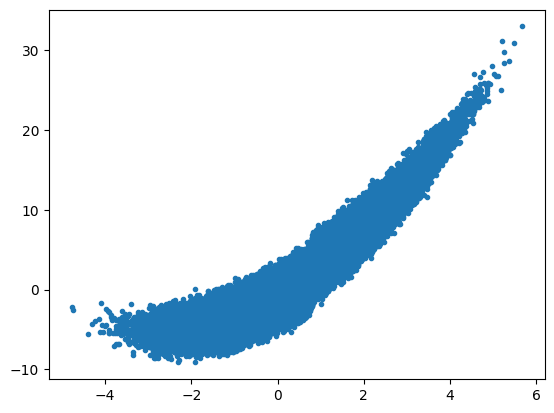

In [258]:
plt.plot(RunningVariable, Y, ".")

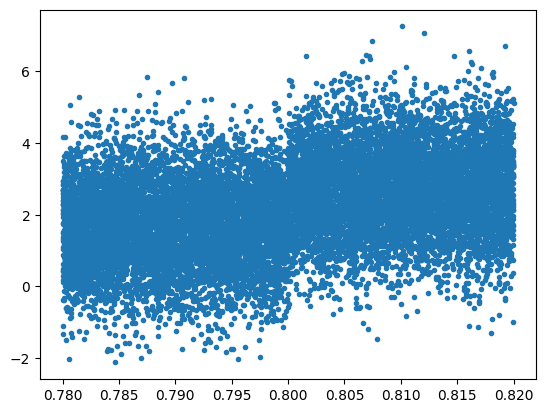

In [259]:
plt.plot(df3.RV, df3.Y, ".")